In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
#Now Max_iter = 1000

In [15]:
# Load the data
data = pd.read_csv('data_matrix.csv')

# Extract features and labels
X = data.drop(columns=['label'])
y = data['label']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))),
    ('svm', make_pipeline(StandardScaler(), SVC())),
    ('rf', RandomForestClassifier())
]


# Define stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())


# Define hyperparameters for random search
param_distributions = {
    'lr__logisticregression__C': [0.1, 1.0, 10.0],
    'svm__svc__C': [0.1, 1.0, 10.0],
    'svm__svc__gamma': ['scale', 'auto'],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 5, 10],
}

In [16]:
# Perform random search
random_search = RandomizedSearchCV(stacking_clf, param_distributions, n_iter=50, cv=4, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best parameters: {random_search.best_params_}")

# Evaluate the model on the test set
test_score = random_search.score(X_test, y_test)
print(f"Test accuracy: {test_score}")

Best parameters: {'svm__svc__gamma': 'auto', 'svm__svc__C': 10.0, 'rf__n_estimators': 200, 'rf__max_depth': None, 'lr__logisticregression__C': 0.1}
Test accuracy: 0.9333333333333333


Accuracy: 0.9303030303030303
Recall: 0.9276315789473685
Precision: 0.9215686274509803
F1 Score: 0.9245901639344262
Confusion Matrix: 
[[166  12]
 [ 11 141]]


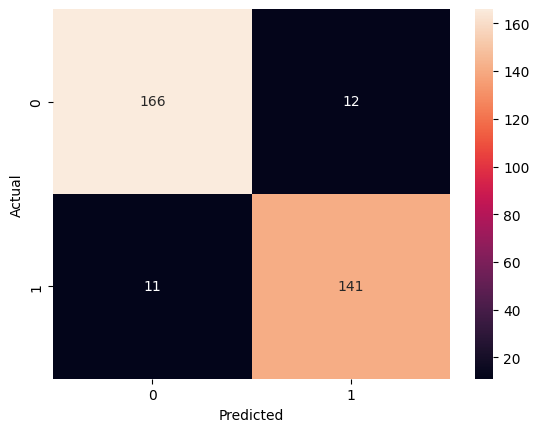

In [26]:
# Use the fitted model to make predictions on the test set
y_pred = random_search.predict(X_test)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# Print precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Print F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Print confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n{confusion_mat}")


# plot the confusion matrix using seaborn
sns.heatmap(confusion_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
# Print accuracy on training set
y_train_pred = random_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Print accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9840909090909091
Test Accuracy: 0.9303030303030303


In [28]:
from sklearn.metrics import accuracy_score

# Extract best parameters from random_search
best_params = random_search.best_params_

# Define models with best parameters
models = [
    ('Logistic Regression', make_pipeline(StandardScaler(), LogisticRegression(C=best_params['lr__logisticregression__C'], max_iter=1000))),
    ('SVM', make_pipeline(StandardScaler(), SVC(C=best_params['svm__svc__C'], gamma=best_params['svm__svc__gamma']))),
    ('Random Forest', RandomForestClassifier(n_estimators=best_params['rf__n_estimators'], max_depth=best_params['rf__max_depth']))
]

for name, model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Compute accuracy
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    print(f"{name}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("-"*30)


Logistic Regression
Training Accuracy: 0.8818181818181818
Test Accuracy: 0.8454545454545455
------------------------------
SVM
Training Accuracy: 0.9598484848484848
Test Accuracy: 0.9212121212121213
------------------------------
Random Forest
Training Accuracy: 0.9924242424242424
Test Accuracy: 0.9212121212121213
------------------------------


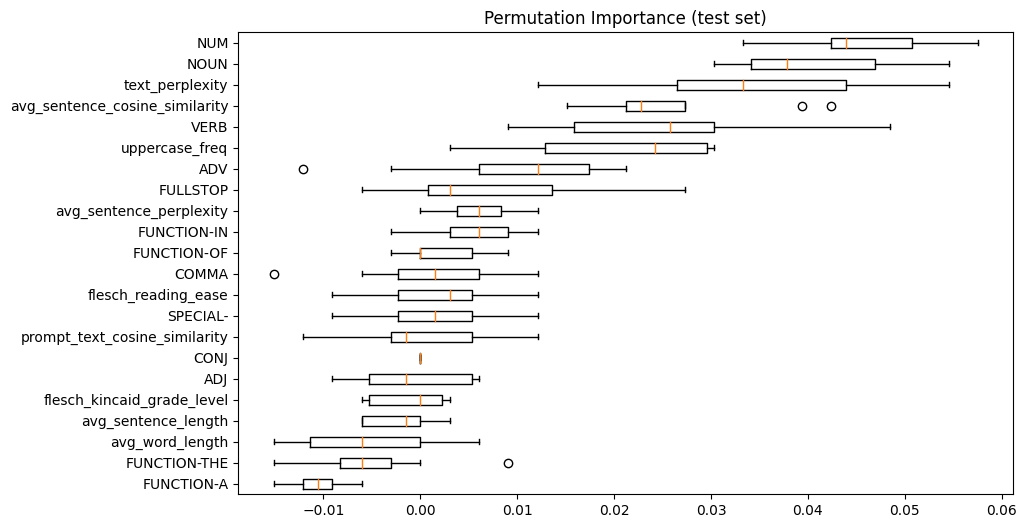

In [29]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation feature importance
result = permutation_importance(random_search.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sort features according to their importance
sorted_idx = result.importances_mean.argsort()

# Plot feature importance
plt.figure(figsize=(10,6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.show()

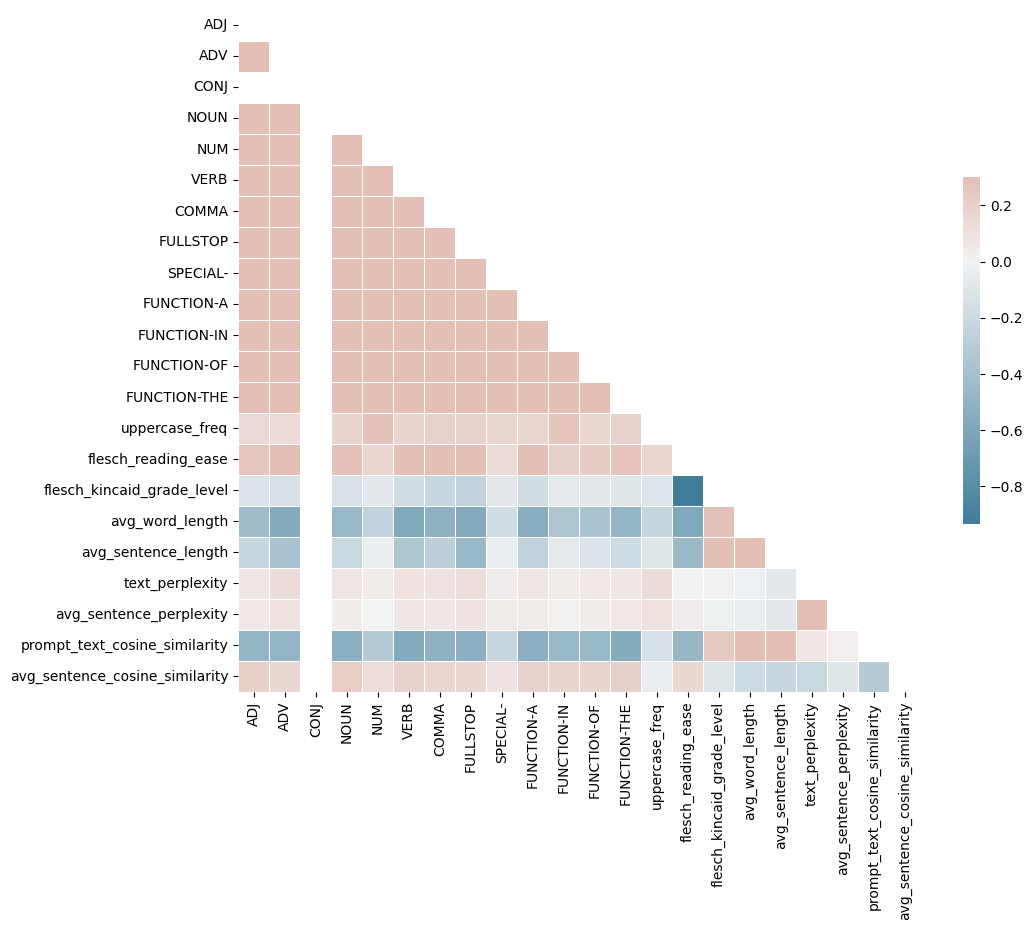

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame for VIF
vif = pd.DataFrame()

# For each column, compute VIF and add it to the DataFrame
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                         variables          VIF
0                              ADJ    18.496415
1                              ADV    12.489316
2                             CONJ          NaN
3                             NOUN    60.851366
4                              NUM     2.934473
5                             VERB    48.152450
6                            COMMA    11.284959
7                         FULLSTOP    26.026883
8                         SPECIAL-     1.719714
9                       FUNCTION-A    10.414138
10                     FUNCTION-IN     7.640188
11                     FUNCTION-OF    10.125205
12                    FUNCTION-THE    16.052610
13                  uppercase_freq     4.186211
14             flesch_reading_ease   114.187970
15      flesch_kincaid_grade_level    50.540682
16                 avg_word_length   425.044262
17             avg_sentence_length    25.558392
18                 text_perplexity   196.328947
19         avg_sentence_perplexity    54

C:\Users\atana\anaconda3\envs\MScProject\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [34]:
# Using describe
desc = X.describe()
print(desc)

# # Using corr
# corr = X.corr()
# print(corr)


               ADJ          ADV    CONJ         NOUN          NUM  \
count  1650.000000  1650.000000  1650.0  1650.000000  1650.000000   
mean     21.852727    13.798182     0.0    62.812727     4.116364   
std      19.078708    17.941077     0.0    55.157590     7.316863   
min       1.000000     0.000000     0.0     3.000000     0.000000   
25%      10.000000     3.000000     0.0    24.250000     0.000000   
50%      17.000000     8.000000     0.0    49.000000     1.000000   
75%      27.000000    18.000000     0.0    76.000000     5.000000   
max     148.000000   157.000000     0.0   370.000000    94.000000   

              VERB        COMMA     FULLSTOP     SPECIAL-   FUNCTION-A  ...  \
count  1650.000000  1650.000000  1650.000000  1650.000000  1650.000000  ...   
mean     43.101212    16.809697    17.358788     1.895758     6.693333  ...   
std      45.159391    19.389848    19.934909     4.034875     7.302393  ...   
min       0.000000     0.000000     0.000000     0.000000     